In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("dataset/power_dataset.csv", sep=";")

In [3]:
df.shape

(14592, 5)

In [4]:
df.head()

,Timestamp,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
0,2019-01-01 00:15:00,"0,00","0,00","14,43","145991,80"
1,2019-01-01 00:30:00,"0,00","0,00","14,35","145991,80"
2,2019-01-01 00:45:00,"0,00","0,00","14,66","145991,80"
3,2019-01-01 01:00:00,"0,00","0,00","14,54","145991,80"
4,2019-01-01 01:15:00,"0,00","0,00","13,79","145991,80"


In [5]:
df[df.columns[1:]] = df[df.columns[1:]].apply(lambda x : [str(i).replace(",",".") for i in x ]) # change everything apart from the first column
df[df.columns[1:]] = df[df.columns[1:]].replace("nan", np.nan)

In [6]:
df.head() # the change from , to . will make the calculations later on much easier.

,Timestamp,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
0,2019-01-01 00:15:00,0.00,0.00,14.43,145991.80
1,2019-01-01 00:30:00,0.00,0.00,14.35,145991.80
2,2019-01-01 00:45:00,0.00,0.00,14.66,145991.80
3,2019-01-01 01:00:00,0.00,0.00,14.54,145991.80
4,2019-01-01 01:15:00,0.00,0.00,13.79,145991.80


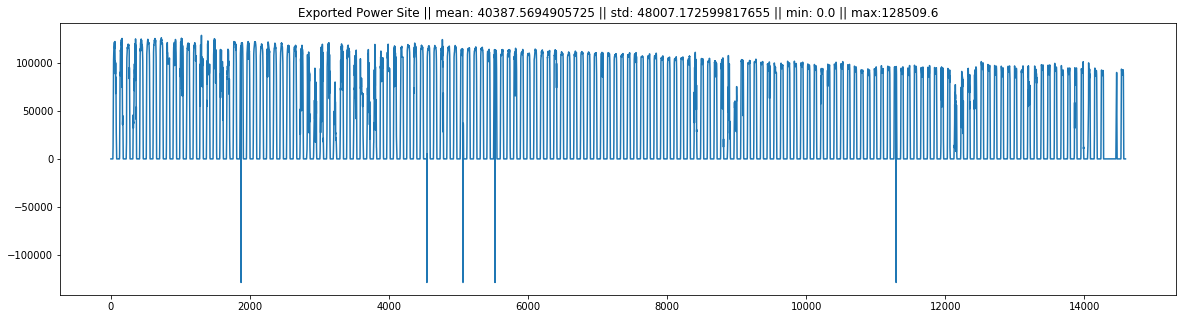

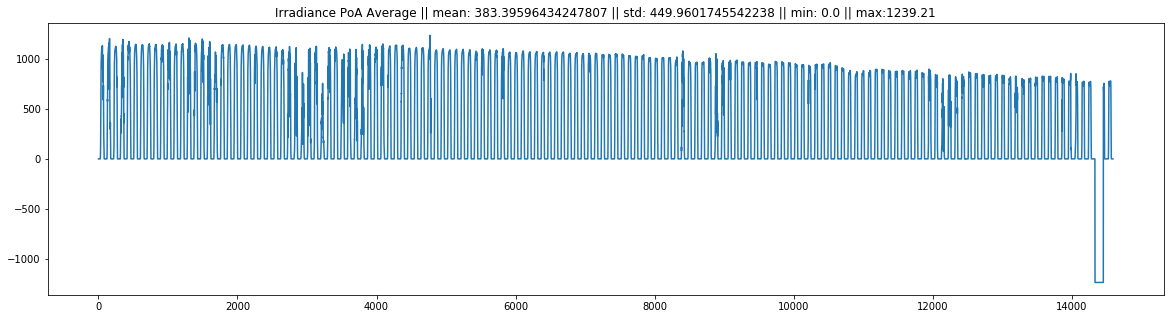

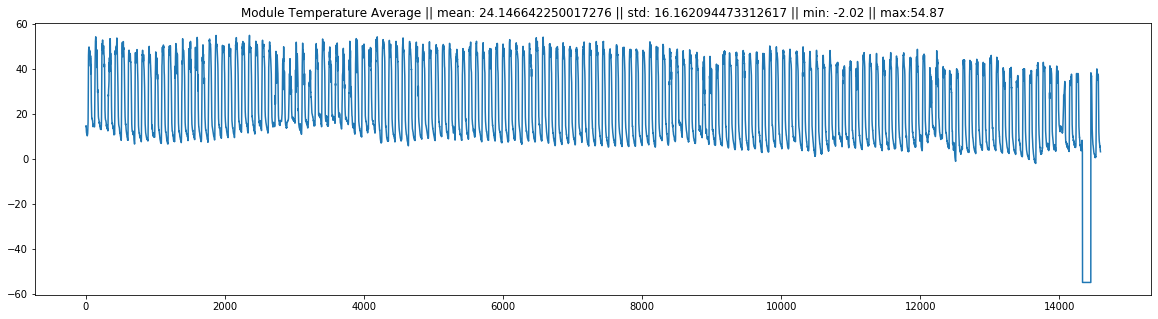

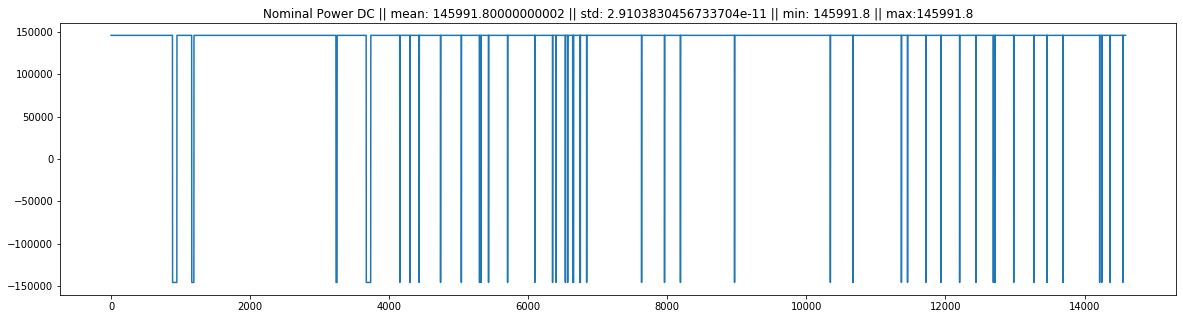

In [17]:
cols = df.columns[1:]
twin_df = df.copy()
twin_df[cols] = twin_df[cols].astype(float)
df_info = {i:"" for i in cols}
for i in cols:
    std = np.std(df[i].astype(float))  # i don't use twin_df here in order not to mess with the calculations
    mn = np.mean(df[i].astype(float))
    minimum = np.min(df[i].astype(float))
    maximum = np.max(df[i].astype(float))
    text = "|| mean: {} || std: {} || min: {} || max:{}".format(mn, std, minimum, maximum)
    
    nan_indicating_value = - np.max(np.abs(df[i].astype(float)))
    
    twin_df[i] = twin_df[i].fillna(nan_indicating_value)
    df_info[i] = {"mean":mn, "std":std, "min":minimum, "max":maximum}
    plt.figure(figsize=(20,5))
    plt.title(i+" "+text)
    plt.plot(twin_df[i]) # in order to check the actual values that would be nan otherwise.
    plt.show()

In [16]:
df_info

{'Exported Power Site': {'mean': 40387.5694905725,
  'std': 48007.172599817655,
  'min': 0.0,
  'max': 128509.6},
 'Irradiance PoA Average': {'mean': 383.39596434247807,
  'std': 449.9601745542238,
  'min': 0.0,
  'max': 1239.21},
 'Module Temperature Average': {'mean': 24.146642250017276,
  'std': 16.162094473312617,
  'min': -2.02,
  'max': 54.87},
 'Nominal Power DC': {'mean': 145991.80000000002,
  'std': 2.9103830456733704e-11,
  'min': 145991.8,
  'max': 145991.8}}

Since we have real values i replaced the occurences of the NaNs with - max value of each collumn (in order to be obvious in the plots above)